In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install diffusers transformers accelerate
!pip install datasets pillow matplotlib tqdm
!pip install wandb tensorboard
!pip install opencv-python scikit-image
!pip install einops

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 4.1 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 4.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 6.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         131G  8.9G  123G   7% /
tmpfs            64M     0   64M   0% /dev
shm              15G     0   15G   0% /dev/shm
/dev/loop6      1.7T  386G  1.3T  24% /etc/hosts
/dev/nvme0n1p2  1.9T  562G  1.2T  32% /usr/bin/nvidia-smi
tmpfs            13G  2.9M   13G   1% /run/nvidia-persistenced/socket
tmpfs            63G     0   63G   0% /sys/fs/cgroup
tmpfs            63G     0   63G   0% /proc/asound
tmpfs            63G     0   63G   0% /proc/acpi
tmpfs            63G     0   63G   0% /proc/scsi
tmpfs            63G     0   63G   0% /sys/firmware
tmpfs            63G     0   63G   0% /sys/devices/virtual/powercap


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
from PIL import Image
import random

# Check GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Current VRAM usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
CUDA Version: 12.1
Available VRAM: 11.66 GB
Current VRAM usage: 0.00 GB


In [2]:
!pip list

Package                   Version
------------------------- --------------
absl-py                   2.3.0
accelerate                1.9.0
aiohappyeyeballs          2.6.1
aiohttp                   3.12.14
aiosignal                 1.4.0
annotated-types           0.7.0
anyio                     4.9.0
argon2-cffi               25.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
bash_kernel               0.10.0
beautifulsoup4            4.13.4
bleach                    6.2.0
blinker                   1.7.0
certifi                   2025.6.15
cffi                      1.17.1
charset-normalizer        3.4.2
click                     8.2.1
comm                      0.2.2
conda-pack                0.8.1
contourpy                 1.3.2
cryptography              41.0.7
cycler                    0.12.1
datasets                  4.0.0
dbus-python   

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Dataset downloaded successfully!
Number of training images: 50000
Image shape: torch.Size([3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size: 128
Number of batches: 391


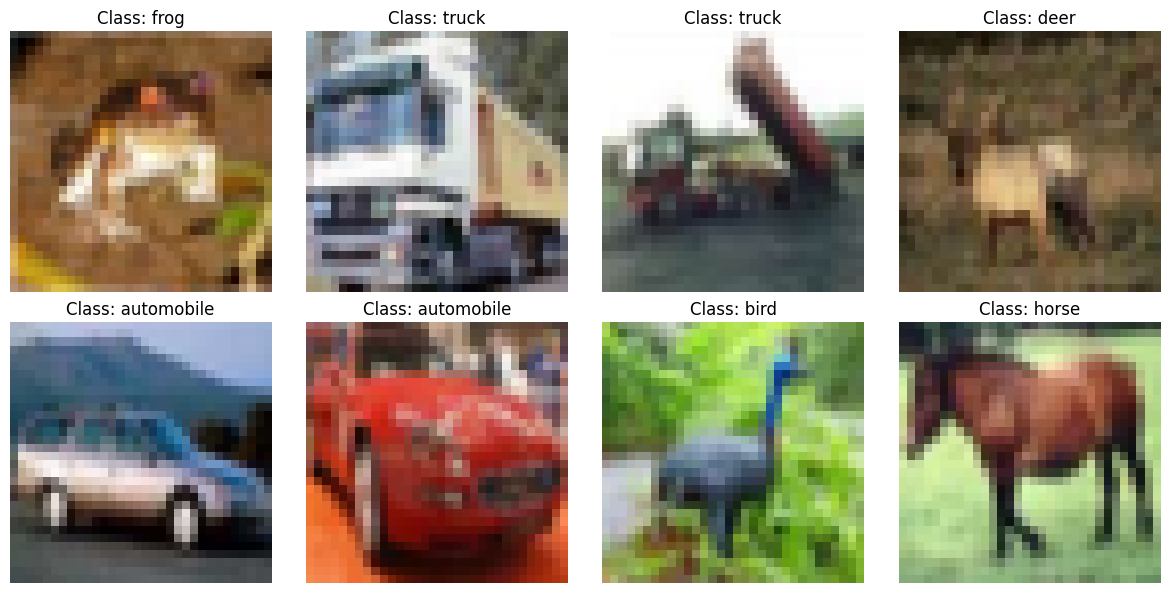

In [3]:
# Step 3: Download and prepare CIFAR-10 dataset
from torchvision import datasets, transforms

# Define data transforms
transform = transforms.Compose([
    transforms.Resize(32),  # CIFAR-10 is 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Download CIFAR-10 dataset
print("Downloading CIFAR-10 dataset...")
train_dataset = datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

print(f"Dataset downloaded successfully!")
print(f"Number of training images: {len(train_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Classes: {train_dataset.classes}")

# Create dataloader
batch_size = 128  # Good for your 12GB VRAM
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(train_loader)}")

# Visualize some samples
def show_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(num_samples):
        img, label = dataset[i]
        # Convert from [-1, 1] to [0, 1] for display
        img = (img + 1) / 2
        img = img.permute(1, 2, 0)
        
        row, col = i // 4, i % 4
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'Class: {dataset.classes[label]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

In [4]:
# Step 4: Define the U-Net architecture for diffusion model

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        self.block1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
        )
        
        self.block2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
        )
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
            
    def forward(self, x, time_emb):
        h = self.block1(x)
        time_emb = self.time_mlp(time_emb)
        h = h + time_emb[:, :, None, None]
        h = self.block2(h)
        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.group_norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.q(h)
        k = self.k(h)
        v = self.v(h)
        
        q = q.reshape(B, C, H*W).permute(0, 2, 1)
        k = k.reshape(B, C, H*W)
        v = v.reshape(B, C, H*W).permute(0, 2, 1)
        
        attn = torch.bmm(q, k) * (int(C) ** (-0.5))
        attn = F.softmax(attn, dim=2)
        
        h = torch.bmm(attn, v)
        h = h.permute(0, 2, 1).reshape(B, C, H, W)
        h = self.proj_out(h)
        
        return x + h

print("Diffusion model components defined successfully!")
print("Next: U-Net architecture")

Diffusion model components defined successfully!
Next: U-Net architecture


In [7]:
# Step 5: Simplified Working U-Net Model

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=128):
        super().__init__()
        
        # Time embedding
        self.time_embedding = TimeEmbedding(time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim * 4),
        )
        
        # Encoder
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.res1 = ResidualBlock(64, 64, time_emb_dim * 4)
        self.down1 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # 32->16
        
        self.res2 = ResidualBlock(64, 128, time_emb_dim * 4)
        self.down2 = nn.Conv2d(128, 128, 3, stride=2, padding=1)  # 16->8
        
        self.res3 = ResidualBlock(128, 256, time_emb_dim * 4)
        self.down3 = nn.Conv2d(256, 256, 3, stride=2, padding=1)  # 8->4
        
        # Middle
        self.mid1 = ResidualBlock(256, 512, time_emb_dim * 4)
        self.mid_attn = AttentionBlock(512)
        self.mid2 = ResidualBlock(512, 512, time_emb_dim * 4)
        
        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)  # 4->8
        self.res_up3 = ResidualBlock(256 + 256, 256, time_emb_dim * 4)
        
        self.up2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)  # 8->16
        self.res_up2 = ResidualBlock(128 + 128, 128, time_emb_dim * 4)
        
        self.up1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # 16->32
        self.res_up1 = ResidualBlock(64 + 64, 64, time_emb_dim * 4)
        
        # Output
        self.output = nn.Sequential(
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv2d(64, out_channels, 3, padding=1),
        )
    
    def forward(self, x, time):
        # Time embedding
        time_emb = self.time_embedding(time)
        time_emb = self.time_mlp(time_emb)
        
        # Encoder
        x1 = self.conv1(x)
        x1 = self.res1(x1, time_emb)
        
        x2 = self.down1(x1)
        x2 = self.res2(x2, time_emb)
        
        x3 = self.down2(x2)
        x3 = self.res3(x3, time_emb)
        
        x4 = self.down3(x3)
        
        # Middle
        x4 = self.mid1(x4, time_emb)
        x4 = self.mid_attn(x4)
        x4 = self.mid2(x4, time_emb)
        
        # Decoder
        x = self.up3(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.res_up3(x, time_emb)
        
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.res_up2(x, time_emb)
        
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.res_up1(x, time_emb)
        
        return self.output(x)

# Initialize model
model = SimpleUNet().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# Test model forward pass
with torch.no_grad():
    test_x = torch.randn(4, 3, 32, 32).to(device)
    test_t = torch.randint(0, 1000, (4,)).to(device)
    test_output = model(test_x, test_t)
    print(f"Test input shape: {test_x.shape}")
    print(f"Test output shape: {test_output.shape}")
    print("Model forward pass successful!")
    
# Check memory usage
print(f"VRAM usage after model creation: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

Model created with 16,808,835 parameters
Test input shape: torch.Size([4, 3, 32, 32])
Test output shape: torch.Size([4, 3, 32, 32])
Model forward pass successful!
VRAM usage after model creation: 0.22 GB


Diffusion scheduler created successfully!


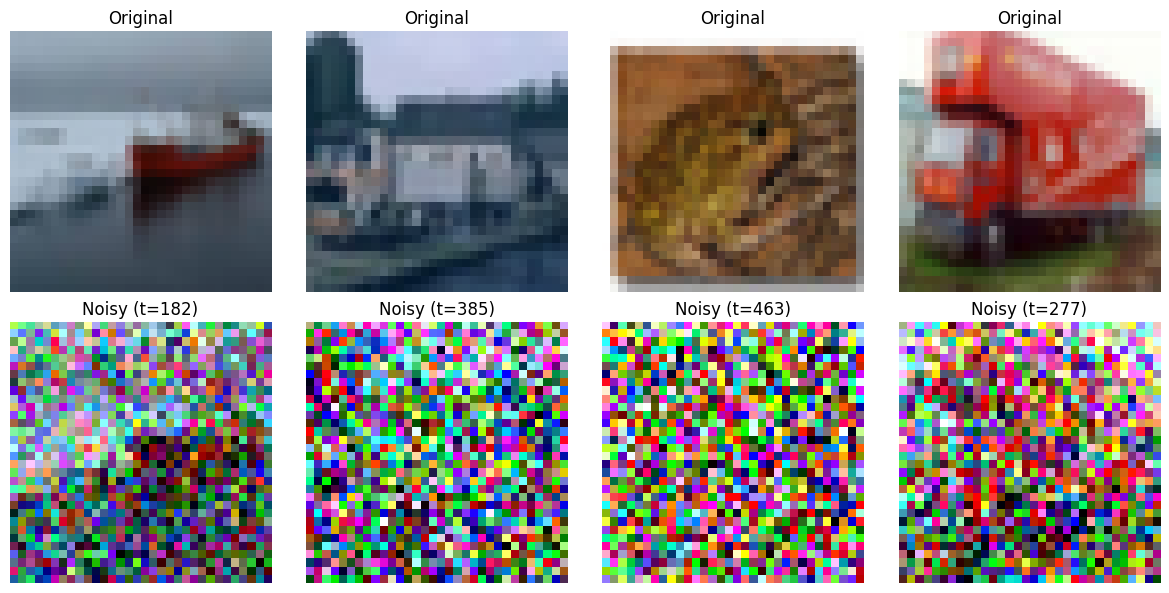

Forward diffusion process test completed!


In [9]:
# Step 6: Define the Diffusion Process (Fixed)

class DDPMScheduler:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), self.alpha_cumprod[:-1]])
        
        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1.0 - self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alpha_cumprod_prev) / (1.0 - self.alpha_cumprod)
        self.posterior_mean_coef2 = (1.0 - self.alpha_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alpha_cumprod)
    
    def add_noise(self, x_start, timesteps, noise=None):
        """Forward diffusion process - add noise to images"""
        if noise is None:
            noise = torch.randn_like(x_start)
        
        # Move timesteps to same device
        timesteps = timesteps.to(self.device)
        
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[timesteps].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[timesteps].reshape(-1, 1, 1, 1)
        
        return sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise
    
    def sample_prev_timestep(self, model_output, timestep, sample):
        """Reverse diffusion process - remove noise from images"""
        timestep = timestep.to(self.device)
        
        # Compute coefficients for predicted original sample (x_0) and current sample (x_t)
        alpha_prod_t = self.alpha_cumprod[timestep]
        alpha_prod_t_prev = self.alpha_cumprod_prev[timestep] if timestep > 0 else torch.tensor(1.0).to(self.device)
        beta_prod_t = 1 - alpha_prod_t
        
        # Compute predicted original sample from predicted noise
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
        
        # Compute coefficients for pred_original_sample and current sample x_t
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * self.betas[timestep]) / beta_prod_t
        current_sample_coeff = self.alphas[timestep] ** (0.5) * (1 - alpha_prod_t_prev) / beta_prod_t
        
        # Compute predicted previous sample
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
        
        return pred_prev_sample

# Initialize scheduler
scheduler = DDPMScheduler(num_timesteps=1000, device=device)
print("Diffusion scheduler created successfully!")

# Test the diffusion process
def test_diffusion_process():
    # Take a batch from our dataset
    data_iter = iter(train_loader)
    images, _ = next(data_iter)
    images = images[:4].to(device)  # Take first 4 images
    
    # Test forward process (adding noise)
    timesteps = torch.randint(0, scheduler.num_timesteps, (4,))
    noise = torch.randn_like(images)
    noisy_images = scheduler.add_noise(images, timesteps, noise)
    
    # Visualize original vs noisy images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    for i in range(4):
        # Original image
        orig_img = (images[i].cpu() + 1) / 2  # Convert from [-1,1] to [0,1]
        orig_img = orig_img.permute(1, 2, 0)
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Noisy image
        noisy_img = (noisy_images[i].cpu() + 1) / 2
        noisy_img = torch.clamp(noisy_img, 0, 1)
        noisy_img = noisy_img.permute(1, 2, 0)
        axes[1, i].imshow(noisy_img)
        axes[1, i].set_title(f'Noisy (t={timesteps[i]})')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Forward diffusion process test completed!")
    return images, noisy_images, timesteps, noise

# Run the test
test_images, test_noisy, test_timesteps, test_noise = test_diffusion_process()

In [10]:
# Step 7: Define Loss Function and Training Setup

def compute_loss(model, batch, scheduler, device):
    """Compute the diffusion loss"""
    images, _ = batch
    images = images.to(device)
    batch_size = images.shape[0]
    
    # Sample random timesteps
    timesteps = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
    
    # Sample noise
    noise = torch.randn_like(images)
    
    # Add noise to images (forward diffusion)
    noisy_images = scheduler.add_noise(images, timesteps, noise)
    
    # Predict noise using model
    predicted_noise = model(noisy_images, timesteps)
    
    # Compute MSE loss between predicted and actual noise
    loss = F.mse_loss(predicted_noise, noise)
    
    return loss

# Training parameters
learning_rate = 1e-4
num_epochs = 20  # Start with fewer epochs for testing
save_every = 5   # Save model every 5 epochs

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-6)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Training setup complete!")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Optimizer: AdamW")
print(f"Batch size: {batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")

# Test the loss computation
print("\nTesting loss computation...")
with torch.no_grad():
    data_iter = iter(train_loader)
    test_batch = next(data_iter)
    test_loss = compute_loss(model, test_batch, scheduler, device)
    print(f"Test loss: {test_loss.item():.4f}")

print("\nMemory usage:")
print(f"Current VRAM usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"Max VRAM usage: {torch.cuda.max_memory_allocated(0) / 1024**3:.2f} GB")

# Training function
def train_epoch(model, train_loader, optimizer, scheduler, device, epoch):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, batch in enumerate(progress_bar):
        optimizer.zero_grad()
        
        # Compute loss
        loss = compute_loss(model, batch, scheduler, device)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        avg_loss = total_loss / (batch_idx + 1)
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{avg_loss:.4f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
        
        # Clear cache every 50 batches to prevent memory buildup
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    return total_loss / num_batches

print("\nReady to start training!")
print("Run the training in the next step...")

Training setup complete!
Learning rate: 0.0001
Number of epochs: 20
Optimizer: AdamW
Batch size: 128
Number of batches per epoch: 391

Testing loss computation...
Test loss: 1.1121

Memory usage:
Current VRAM usage: 0.22 GB
Max VRAM usage: 0.50 GB

Ready to start training!
Run the training in the next step...


In [ ]:
# Step 8: Start Training

import time
import os

# Create directory to save models
os.makedirs('checkpoints', exist_ok=True)

# Training history
train_losses = []
start_time = time.time()

print("Starting training...")
print("=" * 50)

try:
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Train one epoch
        avg_loss = train_epoch(model, train_loader, optimizer, scheduler, device, epoch)
        
        # Update learning rate
        lr_scheduler.step()
        
        # Record loss
        train_losses.append(avg_loss)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s")
        print(f"Average loss: {avg_loss:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"VRAM usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
        
        # Save model checkpoint
        if (epoch + 1) % save_every == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'loss': avg_loss,
                'train_losses': train_losses
            }
            torch.save(checkpoint, f'checkpoints/diffusion_model_epoch_{epoch+1}.pth')
            print(f"Model saved: checkpoints/diffusion_model_epoch_{epoch+1}.pth")
        
        print("-" * 50)
        
        # Clear cache
        torch.cuda.empty_cache()

except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    
# Training completed
total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save final model
final_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
    'loss': train_losses[-1],
    'train_losses': train_losses
}
torch.save(final_checkpoint, 'checkpoints/diffusion_model_final.pth')
print("Final model saved: checkpoints/diffusion_model_final.pth")

print(f"\nFinal training loss: {train_losses[-1]:.4f}")
print(f"Best training loss: {min(train_losses):.4f} at epoch {train_losses.index(min(train_losses))+1}")

Starting training...


Epoch 1/20: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.0746, avg_loss=0.1349, lr=0.000100]



Epoch 1/20 completed in 43.68s
Average loss: 0.1349
Learning rate: 0.000099
VRAM usage: 0.43 GB
--------------------------------------------------


Epoch 2/20:  13%|█▎        | 49/391 [00:05<00:37,  9.10it/s, loss=0.0544, avg_loss=0.0644, lr=0.000099]